# Instructions

1. This exam is worth 20% of the final grade.
2. In the questions below, insert a cell (code or markdown, as appropriate), and fill in your answers there.
2. It is a take-home EXAMINATION to assess your understanding of the material, and extend the ideas by learning on your own. 
2. You are required to work on it individually. Any form of plagiarism will result in 0.
2. Good, efficient Python code will get more marks than code that is not neat, difficult to understand and least importantly, slow.
3. Please submit your notebook file (name it `IND5003_THE_<Your_Name>.ipynb`) through Canvas before **15th Oct 2023 23:59hrs**.

# Data

The files `MRCI_clus_2310.csv` and `MRCI_regr_2310.csv` contain information on institutional characteristics, enrollment, costs, and student outcomes for 856 and 851 four-year colleges, respectively, in the United States of America. The column headings are
* `ADM_RATE`: admission rate
* `SAT_AVG`: average SAT equivalent score of students admitted
* `UGDS`: enrollment of undergraduate degree-seeking students
* `COSTT4_A`: average cost of attendance
* `C150_4`: completion rate for first-time, full-time students (150% of expected time to completion)
* `UGDS_WOMEN`: total share of enrollment of undergraduate degree-seeking students who are women
* `STUFACR`: undergraduate student to instructional faculty ratio
* `MD_EARN_WNE_1YR`: median earnings of graduates working and not enrolled 1 year after completing
* `STATE`: Alabama, Alaska, ..., Wisconsin (the files do not contain colleges in Wyoming)

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import *

# Question 1: Clustering

**Use the data in the file `MRCI_clus_2310.csv`.**

Cluster the colleges on the five variables `ADM_RATE`, `SAT_AVG`, `C150_4`, `UGDS_WOMEN`, and `STUFACR` **after standardisation** using an **appropriately chosen** linkage method for **each of**
1. Euclidean distance
2. Manhattan distance

*You can choose an appropriate linkage method using what is known as the cophenetic correlation coefficient, but include a small paragraph or two on what is the cophenetic correlation coefficient and how you used it to choose your linkage mathod.*

In **each** case, use the silhouette scores to find the optimal or near-optimal number of clusters, and outline the properties/differences of the clusters you identified.

In [2]:
# Impor the data and examine it
clus_df = pd.read_csv("./data/MRCI_clus_2310.csv")
clus_df.head()

,ADM_RATE,SAT_AVG,C150_4,UGDS_WOMEN,STUFACR
0,0.7160,954.0,0.2807,0.5940,18.0
1,0.8854,1266.0,0.6245,0.6210,19.0
2,0.7367,1300.0,0.6072,0.4047,19.0
3,0.9799,955.0,0.2843,0.6495,13.0
4,0.7890,1244.0,0.7223,0.5615,19.0


In [4]:
clus_df.shape

(856, 5)

In [7]:
clus_df.describe()

,ADM_RATE,SAT_AVG,C150_4,UGDS_WOMEN,STUFACR
count,856.000000,856.000000,856.000000,856.000000,856.000000
mean,0.736254,1163.453271,0.600595,0.575898,13.759346
std,0.202226,128.004176,0.162513,0.115135,3.737971
min,0.039500,840.000000,0.157600,0.000000,5.000000
25%,0.646900,1075.750000,0.482050,0.516100,11.000000
50%,0.781300,1139.000000,0.600050,0.576650,13.000000
75%,0.881525,1232.000000,0.708600,0.631125,16.000000
max,1.000000,1535.000000,0.975700,1.000000,30.000000


<Axes: xlabel='ADM_RATE'>

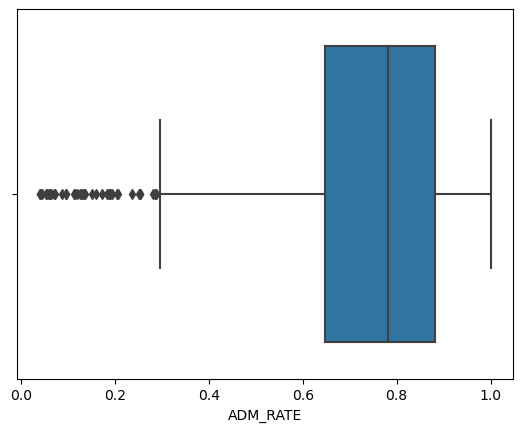

In [9]:
sns.boxplot(x=clus_df["ADM_RATE"])

<Axes: xlabel='SAT_AVG'>

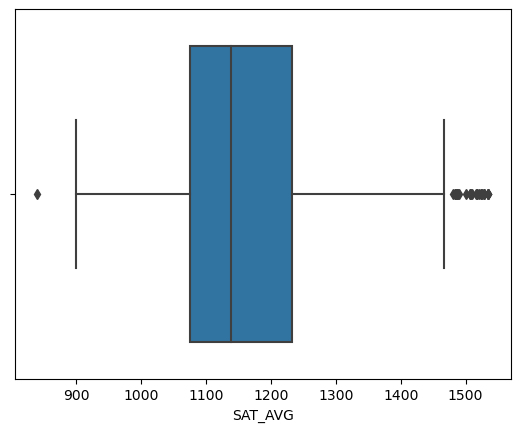

In [10]:
sns.boxplot(x=clus_df["SAT_AVG"])

<Axes: xlabel='C150_4'>

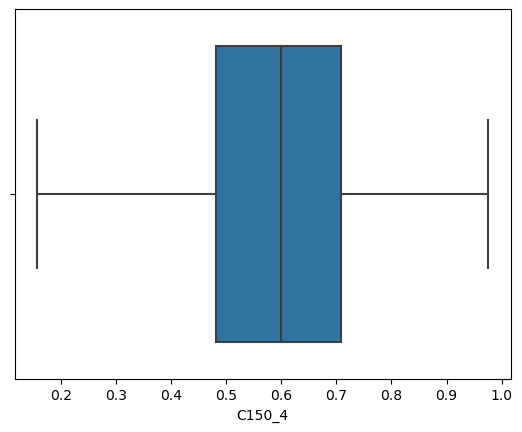

In [11]:
sns.boxplot(x=clus_df["C150_4"])

<Axes: xlabel='SAT_AVG', ylabel='ADM_RATE'>

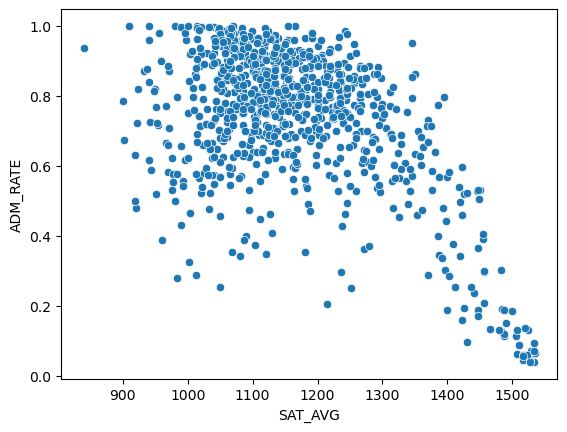

In [6]:
sns.scatterplot(data=clus_df, x="SAT_AVG", y="ADM_RATE")

# Question 2: Regression

**Use the data in the file `MRCI_regr_2310.csv`.**

Use the `statsmodels` package. After you fit a regression model in **each** part, be sure to
* assess its fit,
* study the residuals,
* check for influential points, and
* check for multicollinearity.

*For multicollinearity, you can report what is known as the Variance Inflation Factor (VIF) of the model, but include a small paragraph or two on what is multicollinearity and how it can affect your model.*

1. Fit a regression model of `MD_EARN_WNE_1YR` on all of `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `UGDS_WOMEN` and `STUFACR`. *Do not standardise these variables.* Outline your findings and suggest *a few* other regression models you might consider fitting. *There is no need at this point to fit the regression models you suggested.*

Here are a couple of comments from your boss when you show him/her the analysis:
* "Have you tried standardising the variables `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `UGDS_WOMEN` and `STUFACR`?"
* "Have you tried adding `STATE` to your explanatory variables?"

2. Address his/her questions and other concerns you may have from part 1. You may remove the *most influential* point if it exists. Recommend a final regression model.